In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

In [2]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [4]:
rets = data.pct_change().fillna(0)

In [5]:
from scipy.stats import norm

<Axes: xlabel='Date'>

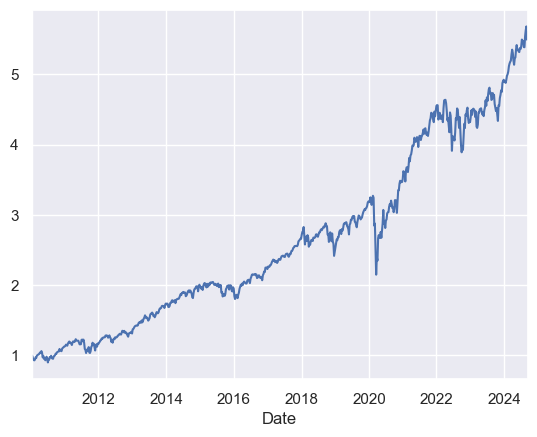

In [6]:
port_rets = rets.mean(axis=1)
(1 + port_rets).cumprod().plot()

<Axes: xlabel='Date'>

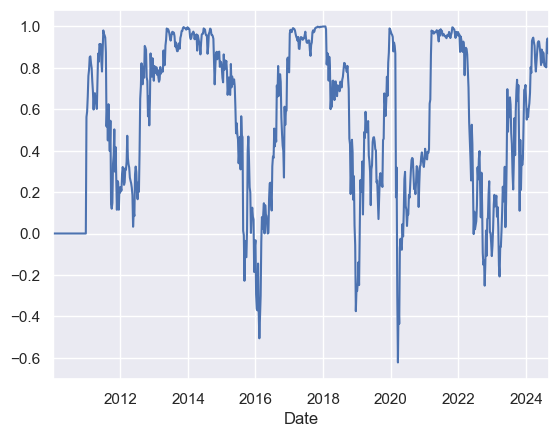

In [8]:
lookback = 52

# 1Year sharpe
sharpe_ratio = (port_rets.rolling(lookback).mean() * np.sqrt(52) / port_rets.rolling(lookback).std())

# Kelly Weight
kl_weights = pd.Series(2 * norm.cdf(sharpe_ratio) - 1, index=port_rets.index).fillna(0)
kl_weights.plot()

<Axes: xlabel='Date'>

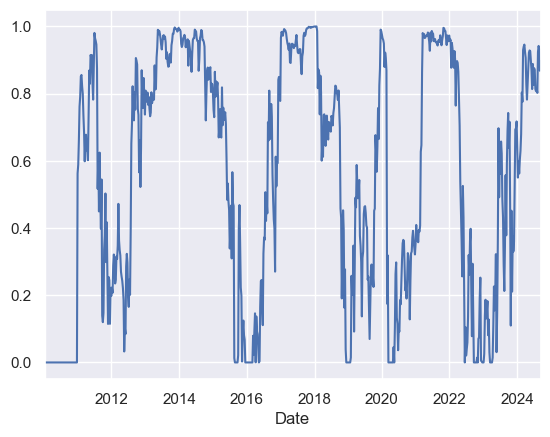

In [9]:
#  Long_Only
kl_weights[kl_weights < 0] = 0
kl_weights.plot()

In [10]:
# Kelly betting PF
kl_rets = (port_rets * kl_weights.shift()).fillna(0)
kl_cum_rets = (1 + kl_rets).cumprod() - 1

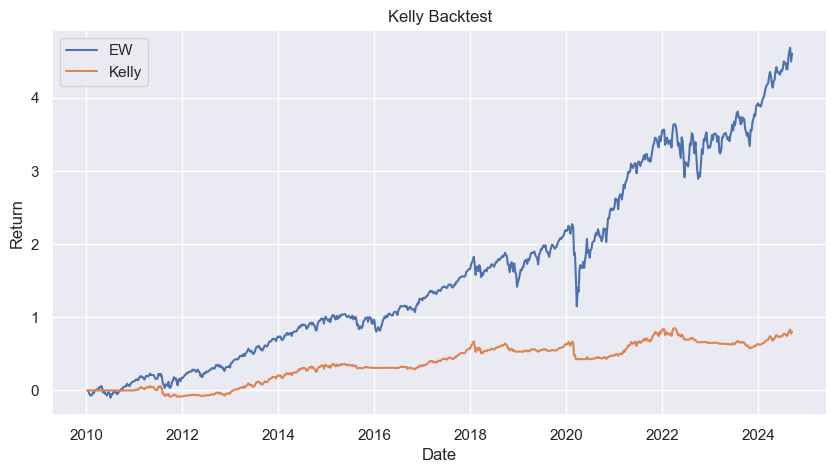

In [11]:
plt.figure(figsize=(10, 5))
plt.plot((1 + port_rets).cumprod() - 1, label='EW')
plt.plot(kl_cum_rets, label='Kelly')
plt.title('Kelly Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

In [12]:
kl_weights_df = pd.concat([kl_weights, 1 - kl_weights], axis=1, join='inner')
kl_weights_df.columns = ['portfolio', 'cash']

Text(0, 0.5, 'Weights')

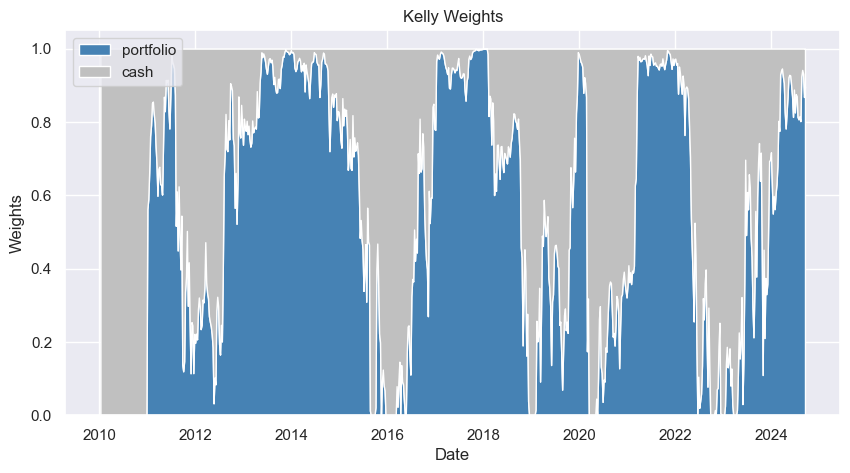

In [13]:
plt.figure(figsize=(10, 5))
plt.stackplot(kl_weights_df.index, kl_weights_df.T, labels=kl_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend(loc='upper left')
plt.title('Kelly Weights')
plt.xlabel('Date')
plt.ylabel('Weights')